In [1]:
import pandas as pd
from io import StringIO, BytesIO
from scipy.io.arff import loadarff
import urllib.request
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
import matplotlib.pyplot as plt
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
cocomonasa2_url = 'http://promise.site.uottawa.ca/SERepository/datasets/cocomonasa_2.arff'
resp2 = urllib.request.urlopen(cocomonasa2_url)
cocomonasa2_data, cocomonasa2_meta = loadarff(StringIO(resp2.read().decode('utf-8')))
cocomonasa2_df = pd.DataFrame(cocomonasa2_data)
cocomonasa2_df.head()

,recordnumber,projectname,cat2,forg,center,year,mode,rely,data,cplx,...,acap,aexp,pcap,vexp,lexp,modp,tool,sced,equivphyskloc,act_effort
0,1.0,b'de',b'avionicsmonitoring',b'g',b'2',1979.0,b'semidetached',b'h',b'l',b'h',...,b'n',b'n',b'n',b'n',b'h',b'h',b'n',b'l',25.9,117.6
1,2.0,b'de',b'avionicsmonitoring',b'g',b'2',1979.0,b'semidetached',b'h',b'l',b'h',...,b'n',b'n',b'n',b'n',b'h',b'h',b'n',b'l',24.6,117.6
2,3.0,b'de',b'avionicsmonitoring',b'g',b'2',1979.0,b'semidetached',b'h',b'l',b'h',...,b'n',b'n',b'n',b'n',b'h',b'h',b'n',b'l',7.7,31.2
3,4.0,b'de',b'avionicsmonitoring',b'g',b'2',1979.0,b'semidetached',b'h',b'l',b'h',...,b'n',b'n',b'n',b'n',b'h',b'h',b'n',b'l',8.2,36.0
4,5.0,b'de',b'avionicsmonitoring',b'g',b'2',1979.0,b'semidetached',b'h',b'l',b'h',...,b'n',b'n',b'n',b'n',b'h',b'h',b'n',b'l',9.7,25.2


In [3]:
cols = cocomonasa2_df.columns
num_cols = cocomonasa2_df._get_numeric_data().columns
nominal_cols = list(set(cols) - set(num_cols))
# transform nominal columns
for col in nominal_cols:
    cocomonasa2_df[col] = cocomonasa2_df[col].astype('category').cat.codes
cocomonasa2_df.head()

,recordnumber,projectname,cat2,forg,center,year,mode,rely,data,cplx,...,acap,aexp,pcap,vexp,lexp,modp,tool,sced,equivphyskloc,act_effort
0,1.0,2,2,1,1,1979.0,2,0,1,0,...,1,2,1,2,0,0,2,1,25.9,117.6
1,2.0,2,2,1,1,1979.0,2,0,1,0,...,1,2,1,2,0,0,2,1,24.6,117.6
2,3.0,2,2,1,1,1979.0,2,0,1,0,...,1,2,1,2,0,0,2,1,7.7,31.2
3,4.0,2,2,1,1,1979.0,2,0,1,0,...,1,2,1,2,0,0,2,1,8.2,36.0
4,5.0,2,2,1,1,1979.0,2,0,1,0,...,1,2,1,2,0,0,2,1,9.7,25.2


In [4]:
cocomonasa2_X = cocomonasa2_df.iloc[:, 1:-1]
cocomonasa2_y = cocomonasa2_df.iloc[:, -1]

In [5]:
def evaluate_model(actual, predicted):
    diff=np.absolute(actual-predicted)
    MRE=diff/actual
    pred = {}
    for x in np.array([.25, .3, .5]):
        P=MRE[MRE<x]
        pred[x] = (P.size/MRE.size) * 100
    return np.mean(MRE), np.median(MRE), pred

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    cocomonasa2_X, cocomonasa2_y, test_size=0.25, random_state=42)

# Comparision

In [48]:
random_grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1,2,3,4,5,6,7,8,9,10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

clf= RandomForestRegressor()
random_grd_search=RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 10, 
                              random_state=42, n_jobs = -1)
random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [49]:
print(random_grd_search.best_params_)
print(random_grd_search.best_score_)

y_predict = random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, y_predict))

{'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1, 'max_depth': 90, 'bootstrap': True}
-1.4790756256913113
(0.9001266685812972, 0.5535225740175475, {0.25: 37.5, 0.3: 37.5, 0.5: 45.83333333333333})


## SVR

In [11]:
svr_params = {'kernel': ('linear','rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
svr= svm.SVR()
svr_random_grd_search=RandomizedSearchCV(estimator = svr, param_distributions = svr_params, n_iter=42, cv = 10, 
                              random_state=42, n_jobs = -1)
svr_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SVR(), n_iter=42, n_jobs=-1,
                   param_distributions={'C': [1.5, 10],
                                        'epsilon': [0.1, 0.2, 0.5, 0.3],
                                        'gamma': [1e-07, 0.0001],
                                        'kernel': ('linear', 'rbf', 'poly')},
                   random_state=42)

In [12]:
print(svr_random_grd_search.best_score_)
print(svr_random_grd_search.best_params_)
svr_y_predict = svr_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, svr_y_predict))

-0.28361041984189134
{'kernel': 'rbf', 'gamma': 0.0001, 'epsilon': 0.2, 'C': 10}
(1.4560117165243611, 0.6544852178646154, {0.25: 16.666666666666664, 0.3: 16.666666666666664, 0.5: 29.166666666666668})


## Decision Tree Regressor

In [17]:
dtr_params={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
dtr = DecisionTreeRegressor()
dtr_random_grd_search=RandomizedSearchCV(estimator = dtr, param_distributions = dtr_params, n_iter=28000, cv = 10, 
                              random_state=42, n_jobs = -1)
dtr_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=28000,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   random_state=42)

In [18]:
print(dtr_random_grd_search.best_score_)
print(dtr_random_grd_search.best_params_)
dtr_y_predict = dtr_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, dtr_y_predict))

-0.1583716040665038
{'splitter': 'random', 'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 2, 'max_leaf_nodes': 10, 'max_features': 'auto', 'max_depth': 11}
(1.295519512368273, 0.7710938084024819, {0.25: 16.666666666666664, 0.3: 20.833333333333336, 0.5: 20.833333333333336})


## Ridge

In [19]:
rr_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}
rr = Ridge()
rr_random_grd_search=RandomizedSearchCV(estimator = rr, param_distributions = rr_params, n_iter=9, cv = 10, 
                              random_state=42, n_jobs = -1)
rr_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=Ridge(), n_iter=9, n_jobs=-1,
                   param_distributions={'alpha': [200, 230, 250, 265, 270, 275,
                                                  290, 300, 500]},
                   random_state=42)

In [20]:
print(rr_random_grd_search.best_score_)
print(rr_random_grd_search.best_params_)
rr_y_predict = rr_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, rr_y_predict))

-2.90321492834964
{'alpha': 200}
(1.9650581807049745, 0.801779912068847, {0.25: 20.833333333333336, 0.3: 20.833333333333336, 0.5: 29.166666666666668})


## Lasso

In [21]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
lasso = Lasso()
lasso_random_grd_search=RandomizedSearchCV(estimator = lasso, param_distributions = lasso_params, n_iter=5, cv = 10, 
                              random_state=42, n_jobs = -1)
lasso_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=Lasso(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': [0.02, 0.024, 0.025, 0.026,
                                                  0.03]},
                   random_state=42)

In [22]:
print(lasso_random_grd_search.best_score_)
print(lasso_random_grd_search.best_params_)
lasso_y_predict = lasso_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, lasso_y_predict))

-8.820520923476153
{'alpha': 0.03}
(2.4608211781371483, 0.8948859539356382, {0.25: 8.333333333333332, 0.3: 12.5, 0.5: 37.5})


## AdaBoost

In [23]:
abr_params = {'n_estimators': [50, 100, 200],
              'learning_rate' : [0.01,0.05,0.1,0.3,1],
              'loss' : ['linear', 'square', 'exponential'],
              'random_state': [0,1]
             }
abr = AdaBoostRegressor()
abr_random_grd_search=RandomizedSearchCV(estimator = abr, param_distributions = abr_params, n_iter=90, cv = 10, 
                              random_state=42, n_jobs = -1)
abr_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=AdaBoostRegressor(), n_iter=90, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100, 200],
                                        'random_state': [0, 1]},
                   random_state=42)

In [24]:
print(abr_random_grd_search.best_score_)
print(abr_random_grd_search.best_params_)
abr_y_predict = abr_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, abr_y_predict))

-5.747273253972013
{'random_state': 0, 'n_estimators': 50, 'loss': 'linear', 'learning_rate': 1}
(1.6290573333597314, 0.753484126984127, {0.25: 25.0, 0.3: 29.166666666666668, 0.5: 41.66666666666667})


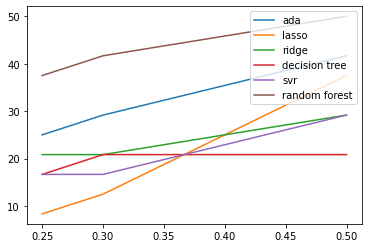

In [30]:
import matplotlib.pyplot as plt
import numpy as np

x = [.25, .3, .5]
plt.plot(x, [25.0, 29.166666666666668,41.66666666666667])
plt.plot(x, [8.333333333333332, 12.5, 37.5])
plt.plot(x, [20.833333333333336, 20.833333333333336, 29.166666666666668])
plt.plot(x, [16.666666666666664, 20.833333333333336, 20.833333333333336])
plt.plot(x, [16.666666666666664, 16.666666666666664, 29.166666666666668])
plt.plot(x, [37.5, 41.66666666666667, 50.0])

plt.legend(['ada','lasso', 'ridge', 'decision tree', 'svr', 'random forest'], loc='upper right')

plt.show()

In [47]:
mmre = [[0.8536396704719538, 1.4560117165243611, 1.295519512368273, 1.9650581807049745, 2.4608211781371483, 1.6290573333597314],
        [1.9750227995986425, 1.2224320421097654, 31.942580829653416, 5.752009352326873, 44.50489631074747, 2.7383416295016723]]
mdre = [[0.541383435960885, 0.6544852178646154, 0.7710938084024819, 0.801779912068847, 0.8948859539356382, 0.753484126984127], 
        [1.3135616776315793, 0.6566375398144461, 12.730323426573428, 2.8161613161074257, 19.068289800604422, 0.9562568344645551]]
pred = [[37.5, 16.666666666666664, 16.666666666666664, 20.833333333333336, 8.333333333333332, 25.0 ], 
        [6.25, 25.0, 0.0, 6.25, 12.5, 12.5]]
eff = np.zeros((2,6))
min_mmre_81=min(mmre[1])
max_mmre_81=max(mmre[1])
min_pred_81=min(pred[1])
max_pred_81=max(pred[1])
min_mdre_81=min(mdre[1])
max_mdre_81=max(mdre[1])
for i in range(2):
    min_mmre=min(mmre[i])
    max_mmre=max(mmre[i])
    min_pred=min(pred[i])
    max_pred=max(pred[i])
    min_mdre=min(mdre[i])
    max_mdre=max(mdre[i])
    for j in range(6):
        Aij = 1- (mmre[i][j]-min_mmre)/(max_mmre-min_mmre)
        Bij = 1- (mdre[i][j]-min_mdre)/(max_mdre-min_mdre)
        Cij = 1- (pred[i][j]-min_pred)/(max_pred-min_pred)
        Xij = (Aij+Bij+Cij)/3
        if Xij<=0.3:
            eff[i][j]=Xij
        elif Xij > 0.7:
            eff[i][j]=Xij
        else: 
            eff[i][j]=Xij
print(eff)

[[0.66666667 0.67317976 0.59651077 0.38109249 0.33333333 0.44870108]
 [0.89897744 0.66666667 0.54482567 0.84268577 0.16666667 0.81623433]]
